# CAM Visualization

### import keras model

In [1]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


### import matplotlib, numpy, cv2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import cv2

### import cam module

In [3]:
from gradcam import load_image, GradCAM, CAM

### read image path

In [4]:
from os import listdir
from os.path import isfile, join

img_dir = "../images/"

img_paths = [img_dir + f for f in listdir(img_dir) if isfile(join(img_dir, f))]

In [5]:
img_paths

['../images/cat.jpg',
 '../images/cat_dog.jpg',
 '../images/dorm.jpg',
 '../images/elephant.jpg',
 '../images/husky.jpg']

### generate cam(class activation map)

In [6]:
img_width = 224
img_height = 224

model = ResNet50(weights='imagenet')
activation_layer = 'activation_49'

cams = []
gradcams = []
cam_weights = []
gradcam_weights = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))

    preds = model.predict(img)
    predicted_class = preds.argmax(axis=1)[0]
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print("predicted top1 class:", predicted_class)
    print('Predicted:', decode_predictions(preds, top=1)[0])
    # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

    cam_generator = CAM(model, activation_layer, predicted_class)
    gardcam_generator = GradCAM(model, activation_layer, predicted_class)
    
    cam, cam_weight = cam_generator.generate(img)
    cams.append(cam)
    cam_weights.append(cam_weight)
    
    gradcam, gradcam_weight = gardcam_generator.generate(img)
    gradcams.append(gradcam)
    gradcam_weights.append(gradcam_weight)

predicted top1 class: 277
Predicted: [('n02119022', 'red_fox', 0.27037323)]
predicted top1 class: 243
Predicted: [('n02108422', 'bull_mastiff', 0.30042636)]
predicted top1 class: 698
Predicted: [('n03877845', 'palace', 0.98025954)]
predicted top1 class: 386
Predicted: [('n02504458', 'African_elephant', 0.71317613)]
predicted top1 class: 248
Predicted: [('n02109961', 'Eskimo_dog', 0.6967269)]


### Guided Backpropagation

In [7]:
import sys
sys.path.insert(0, '../utils')
sys.path.insert(0, '../keras-GuidedBackpropagation')

from utils import deprocess_image
from vis_convolution import VisConvolution

vis_conv = VisConvolution(model, ResNet50, activation_layer)

gradient = []
for img_path in img_paths:
    img = load_image(path=img_path, target_size=(img_width, img_height))
    gradient.append(vis_conv.generate(img))

### Plot CAM

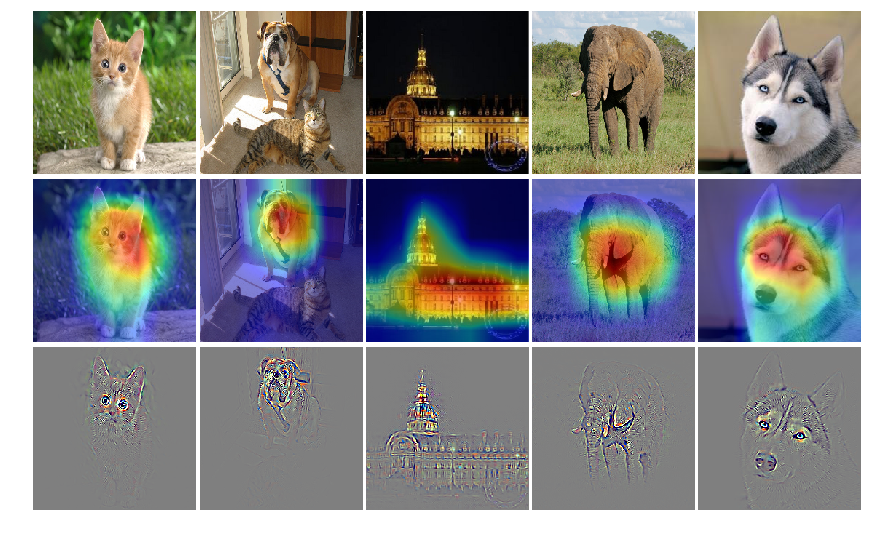

In [8]:
plt.figure(figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.7    # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.02  # the amount of width reserved for blank space between subplots
hspace = 0.0   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=wspace, hspace=hspace)

for idx in range(len(cams)):
    cams[idx] = cv2.resize(cams[idx], (img_width, img_height))
    gradcams[idx] = cv2.resize(gradcams[idx], (img_width, img_height))
    
    img = cv2.imread(img_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    
    plt.subplot(3, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(3, 5, 5 + idx+1)
    plt.imshow(img)
    plt.imshow(gradcams[idx], cmap="jet", alpha=.5)
    plt.axis('off')
    
    guided_gradcam = gradient[idx] * gradcams[idx][..., np.newaxis]
    guided_gradcam = deprocess_image(guided_gradcam)
    guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_RGB2BGR)
    plt.subplot(3, 5, 10 + idx+1)
    plt.imshow(guided_gradcam)
    plt.axis('off')

### compare 

$$a_k^c = \frac{1}{Z}\sum _i\sum_j\frac{\partial y^c}{\partial A^k_{i,j}}$$ 

$$w_k^c = \sum _i\sum_j\frac{\partial y^c}{\partial A^k_{i,j}}$$ 

$$Za_k^c = w_k^c$$

- activation conv layer의 shape 계산
- Z (activation conv 출력 feature map의 pixel 수)

In [9]:
print(model.get_layer('activation_49').output_shape[1:3])
Z = model.get_layer('activation_49').output_shape[1] * model.get_layer('activation_49').output_shape[2]

(7, 7)


In [10]:
print(cam_weights[0])
print(gradcam_weights[0] * Z)

[-0.02482816 -0.00089641 -0.01539475 ... -0.02615959 -0.05278322
  0.00466108]
[-0.02482816 -0.0008964  -0.01539475 ... -0.0261596  -0.05278322
  0.00466108]
